In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import holidays
import networkx as nx
from pandas.api.types import is_numeric_dtype, is_bool_dtype, is_object_dtype, is_categorical_dtype, CategoricalDtype
import shap # For SHAP values
import warnings; warnings.filterwarnings('ignore', category=DeprecationWarning)

# --- Scikit-learn ---
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics.pairwise import rbf_kernel
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

# --- EconML for Causal ML ---
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

from causallearn.utils.cit import fisherz
from causallearn.search.ConstraintBased.PC import pc 
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
import dowhy
from dowhy import CausalModel
import causalml
from causalml.inference.meta import BaseXRegressor # X-Learner implementation
from causalml.metrics import plot_gain, plot_qini



# --- Plotting Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (11, 6)
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "Times New Roman"
%matplotlib inline

In [89]:
fpath = '../datasets/processed/final_df.csv'
df = pd.read_csv(fpath)
print(f"Successfully loaded processed data!")
if df.isnull().sum().sum() == 0:
    print("Data has no missing values.")

Successfully loaded processed data!
Data has no missing values.


In [90]:
bool_cols = ['Q_2', 'Q_3', 'Q_4', 
             'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 
             'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas'] 
for col in bool_cols:
    if col in df.columns: df[col] = df[col].astype(float).astype(bool)
int_cols = ['passengers', 'Year', 'nsmiles', 'lg_carrier_is_lcc'] 
for col in int_cols:
    if col in df.columns: 
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Year                   115032 non-null  Int64  
 1   citymarketid_1         115032 non-null  int64  
 2   citymarketid_2         115032 non-null  int64  
 3   city1                  115032 non-null  object 
 4   city2                  115032 non-null  object 
 5   nsmiles                115032 non-null  Int64  
 6   passengers             115032 non-null  Int64  
 7   fare                   115032 non-null  float64
 8   large_ms               115032 non-null  float64
 9   fare_lg                115032 non-null  float64
 10  carrier_low            115032 non-null  object 
 11  lf_ms                  115032 non-null  float64
 12  fare_low               115032 non-null  float64
 13  origin_fare_premium    115032 non-null  float64
 14  origin_perc_lcc_pax    115032 non-nu

## 2. Define Causal Analysis Variables

In [91]:
OUTCOME_CAUSAL = 'passengers'
TREATMENT_CAUSAL = 'fare'
print(f"Outcome (Y): {OUTCOME_CAUSAL}")
print(f"Treatment (T): {TREATMENT_CAUSAL}")

Outcome (Y): passengers
Treatment (T): fare


In [92]:
CONFOUNDERS_CAUSAL = [
    'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium',
    'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax',
    'Year', 'lg_carrier_is_lcc', 'Q_2', 'Q_3', 'Q_4',
    'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas', 'is_Q_with_Any_Holiday',
    'carrier_WN', 'carrier_DL', 'carrier_AA'
]

confounders_causal = [f for f in CONFOUNDERS_CAUSAL if f in df.columns]
print(f"Confounders (W): {confounders_causal}")

Confounders (W): ['nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'lg_carrier_is_lcc', 'Q_2', 'Q_3', 'Q_4', 'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas', 'is_Q_with_Any_Holiday', 'carrier_WN', 'carrier_DL', 'carrier_AA']


In [93]:
# Features for Heterogeneity (X_het) - variables across which the treatment effect might vary
# Often a subset of W, or specific interaction candidates
FEATURES_HETEROGENEITY = [
    'nsmiles', # effect might differ by distance
    'large_ms', # effect might differ by market concentration
    'lg_carrier_is_lcc', 'origin_fare_premium',
    'distance_cat', 'premium_cat', 'Q_2', 'Q_3', 'Q_4', 
    'carrier_WN', 'carrier_DL', 'carrier_AA'
    'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas'
]
features_heterogeneity = [f for f in FEATURES_HETEROGENEITY if f in df.columns]
print(f"Features for Heterogeneity (X_het): {features_heterogeneity}")

Features for Heterogeneity (X_het): ['nsmiles', 'large_ms', 'lg_carrier_is_lcc', 'origin_fare_premium', 'Q_2', 'Q_3', 'Q_4', 'carrier_WN', 'carrier_DL', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas']


In [94]:
numerical_features_to_scale = [
    'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium',
    'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year'
]
numerical_features_to_scale = [f for f in numerical_features_to_scale if f in df.columns]
print(f"Numerical features for scaling: {numerical_features_to_scale}")

Numerical features for scaling: ['nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year']


## 3. Create the ground truth

In [95]:
df['holiday_intensity'] = df[
    ['is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep',
     'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas']
].sum(axis=1)

In [96]:
G = nx.DiGraph()

selected_features = [
    'fare',                 # Treatment (T)
    'passengers',           # Outcome (Y)
    'nsmiles',              # Confounder / Het. Feature (W/X)
    'large_ms',             # Confounder / Het. Feature (W/X)
    'Year',                 # Confounder (W - Time Trend)
    'lg_carrier_is_lcc',    # Confounder / Het. Feature (W/X)
    'origin_fare_premium',  # Confounder / Het. Feature (W/X)
    #'Q_2', 'Q_3', 'Q_4', 
    'holiday_intensity'
]
df_SF = df[selected_features]
display(df_SF)

,fare,passengers,nsmiles,large_ms,Year,lg_carrier_is_lcc,origin_fare_premium,holiday_intensity
0,159.59,16339,372,0.5209,2024,1,-0.00156,2
1,179.57,15842,1118,0.2565,2024,1,-0.10750,2
2,399.68,13767,2510,0.2642,2024,1,-0.00156,2
3,176.63,12511,989,0.4043,2024,1,0.03358,2
4,184.79,11466,773,0.4137,2024,0,-0.00315,2
...,...,...,...,...,...,...,...,...
115027,138.88,111,550,0.2600,1996,0,-0.14690,1
115028,199.92,111,381,0.8400,1996,0,0.10675,1
115029,95.23,111,852,0.9300,1996,1,-0.48910,1
115030,164.99,110,1481,0.3000,1996,0,-0.16440,1


In [97]:
causal_nodes = [node for node in selected_features if node in df.columns]
confounders = [node for node in causal_nodes if node not in ['fare', 'passengers']]
treatment_node = 'fare'
outcome_node = 'passengers'
G.add_nodes_from(causal_nodes)

In [98]:
edges = []
for w in confounders:
    edges.append((w, treatment_node)) # add edge W -> T
    edges.append((w, outcome_node))   # add edge W -> Y

# Add the main edge of interest from Treatment (T) to Outcome (Y)
edges.append((treatment_node, outcome_node)) # add T -> Y

G.add_edges_from(edges)

In [99]:
# Generate adjacency matrix
adj_matrix_GT = nx.adjacency_matrix(G, nodelist=causal_nodes).todense()
adj_df_GT = pd.DataFrame(adj_matrix_GT, columns=causal_nodes, index=causal_nodes)

# Print the adjacency matrix
print("Adjacency Matrix (Ground Truth):") 
print(adj_df_GT)

# Save the adjacency matrix as a .npy file
np.save('../outputs/ground_truth.npy', adj_df_GT.to_numpy())

Adjacency Matrix (Ground Truth):
                     fare  passengers  nsmiles  large_ms  Year  \
fare                    0           1        0         0     0   
passengers              0           0        0         0     0   
nsmiles                 1           1        0         0     0   
large_ms                1           1        0         0     0   
Year                    1           1        0         0     0   
lg_carrier_is_lcc       1           1        0         0     0   
origin_fare_premium     1           1        0         0     0   
holiday_intensity       1           1        0         0     0   

                     lg_carrier_is_lcc  origin_fare_premium  holiday_intensity  
fare                                 0                    0                  0  
passengers                           0                    0                  0  
nsmiles                              0                    0                  0  
large_ms                             0          

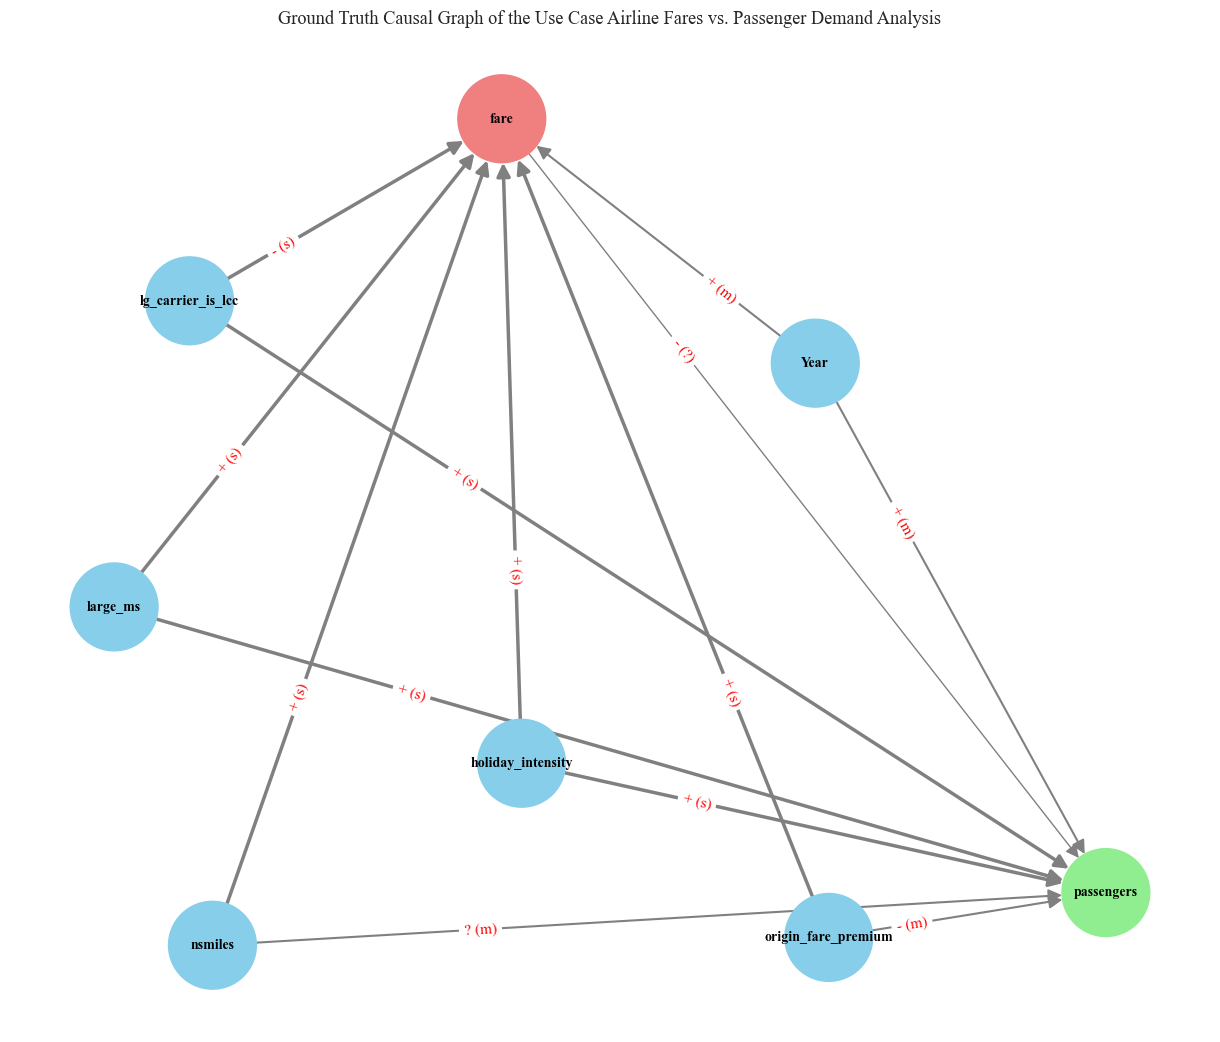

In [100]:
# Plot the causal graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.8)
        
node_colors = []
for node in G.nodes():
    if node == treatment_node:
        node_colors.append('lightcoral')
    elif node == outcome_node:
        node_colors.append('lightgreen')
    else:
        node_colors.append('skyblue')

# Add edge labels
edge_labels = {
    ('nsmiles', treatment_node): '+ (s)', # long distance -> higher fare
    ('large_ms', treatment_node): '+ (s)', # large market share -> higher fare (brand loyalty, pricing power)
    ('Year', treatment_node): '+ (m)', # year trend -> higher fare (inflation, fuel costs)
    ('lg_carrier_is_lcc', treatment_node): '- (s)', # low-cost carrier -> lower fare
    ('origin_fare_premium', treatment_node): '+ (s)', # high-cost airports -> higher fare
    ('holiday_intensity', treatment_node): '+ (s)', # holiday season -> higher fare
    
    ('nsmiles', outcome_node): '? (m)', # long distance ? passenger demand
    ('large_ms', outcome_node): '+ (s)', # large market share -> higher demand
    ('Year', outcome_node): '+ (m)', # long-term trend shows moderate growth in demand
    ('lg_carrier_is_lcc', outcome_node): '+ (s)',
    ('origin_fare_premium', outcome_node): '- (m)',
    ('holiday_intensity', outcome_node): '+ (s)', # holiday season -> higher fare
    
    (treatment_node, outcome_node): '- (?)'
}

edge_weights = []
for u, v in G.edges():
    label = edge_labels.get((u, v), '')
    if '(s)' in label:
        edge_weights.append(2.5)
    elif '(m)' in label:
        edge_weights.append(1.5)
    else:
        edge_weights.append(1.0)

nx.draw(G, pos, with_labels=True, node_size=4000,
        node_color=node_colors, font_size=10,
        font_color='black', font_weight='bold',
        arrows=True, arrowsize=20,
        edge_color='gray', width=edge_weights)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=11, 
                             label_pos=0.7)

plt.title('Ground Truth Causal Graph of the Use Case Airline Fares vs. Passenger Demand Analysis')
plt.savefig('../outputs/R_causal_ground_truth.png', dpi=300)
plt.show()

In [101]:
df_GT = np.load('../outputs/ground_truth.npy')
print(df_GT)
print(type(df_GT))
print(df_GT.shape)
print(df_GT.dtype)

[[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]]
<class 'numpy.ndarray'>
(8, 8)
int64


## 4. Causal ML for Price Impact Estimation (Explanation)

In [102]:
# Goal: Estimate the causal effect of 'fare' (T) on 'passengers' (Y),
# Controlling for confounders 'W'.

### 4.1. Prepare Data for Causal Model

In [103]:
Y = df[OUTCOME_CAUSAL].astype(float)
T = df[TREATMENT_CAUSAL].astype(float)
W = df[confounders_causal].copy() # confounders
X_het = df[features_heterogeneity].copy() # features for heterogeneity

In [104]:
# Convert boolean dummies in W and X_het to int (0/1) for econml models
print("Converting boolean/Int64 columns in W and X_het for econml...")
for df_causal in [W, X_het]:
    for col in df_causal.columns:
    # Convert potential boolean columns to int
        if is_bool_dtype(df_causal[col]):
            df_causal[col] = df_causal[col].astype(int)
        elif pd.api.types.is_integer_dtype(df_causal[col]):
            df_causal[col] = df_causal[col].astype(float)

Converting boolean/Int64 columns in W and X_het for econml...


In [105]:
print("\n Dtypes for W after conversion:")
W.info(verbose=False)
print("\n Dtypes for X_het after conversion:")
X_het.info(verbose=False)


 Dtypes for W after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Columns: 22 entries, nsmiles to carrier_AA
dtypes: float64(13), int64(9)
memory usage: 19.3 MB

 Dtypes for X_het after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Columns: 14 entries, nsmiles to is_Q_with_Christmas
dtypes: float64(6), int64(8)
memory usage: 12.3 MB


### 4.2. Preprocessing (Scaling Confounders and Heterogeneity Features)

In [106]:
# Identify numeric columns within W and X_het that need scaling
num_W_to_scale = [col for col in W.columns if col in numerical_features_to_scale]
num_Xhet_to_scale = [col for col in X_het.columns if col in numerical_features_to_scale]

In [107]:
# Scaler for W
scaler_W = StandardScaler()
W[num_W_to_scale] = scaler_W.fit_transform(W[num_W_to_scale])
print(f"Scaled numerical confounders (W): {num_W_to_scale}")

Scaled numerical confounders (W): ['nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year']


In [108]:
# Scaler for X_het
scaler_Xhet = StandardScaler()
X_het[num_Xhet_to_scale] = scaler_Xhet.fit_transform(X_het[num_Xhet_to_scale])
print(f"Scaled numerical heterogeneity features (X_het): {num_Xhet_to_scale}")


Scaled numerical heterogeneity features (X_het): ['nsmiles', 'large_ms', 'origin_fare_premium']


### 4.3. Estimate Average Treatment Effect (ATE) using LinearDML

In [109]:
# Define nuisance models
model_y_gbt = GradientBoostingRegressor(n_estimators=100, max_depth=4, min_samples_leaf=10, random_state=42)
model_t_gbt = GradientBoostingRegressor(n_estimators=100, max_depth=4, min_samples_leaf=10, random_state=123)

In [110]:
# Initialize LinearDML estimator
dml_estimator = LinearDML(model_y=model_y_gbt, model_t=model_t_gbt, discrete_treatment=False, cv=5, random_state=42)

In [111]:
# Convert to numpy arrays for econml fit method
Y_np = Y.values.ravel()
T_np = T.values.ravel()
W_np = W.values; X_het_np = X_het.values

In [112]:
print(f"Fitting LinearDML model (Y:{Y_np.shape}, T:{T_np.shape}, W:{W_np.shape})...")
# W contains confounders; X is None because LinearDML effect is constant by default
dml_estimator.fit(Y_np, T_np, X=None, W=W_np, inference='auto')

Fitting LinearDML model (Y:(115032,), T:(115032,), W:(115032, 22))...


In [113]:
# Get the ATE summary
print("\nLinearDML ATE Summary:")
ate_summary = dml_estimator.summary(alpha=0.05) # 95% confidence interval (CI)
print(ate_summary)

ate_inference_results = dml_estimator.effect_inference()

ate_point_estimate_val = ate_inference_results.point_estimate
ate_stderr_val = ate_inference_results.stderr
ate_pvalue_val = ate_inference_results.pvalue()

ate_point_estimate = ate_point_estimate_val.item() 
ate_stderr = ate_stderr_val.item() 
ate_pvalue = ate_pvalue_val.item()

print(f"\nEstimated Average Treatment Effect (ATE) of Fare on Passengers: {ate_point_estimate:.3f}")
print(f"Standard Error: {ate_stderr:.3f}")
print(f"P-value: {ate_pvalue:.3f}")

print("\nInterpretation of ATE:")
print(f"On average, across all routes and time periods, a $1 increase in 'fare'")
print(f"is estimated to cause a change of approximately {ate_point_estimate:.1f} passengers per day,")
print(f"after controlling for the confounding effects of specified W variables.")

if ate_pvalue < 0.05: 
    print("This effect is statistically significant at the 5% level.")
else: 
    print("This effect is not statistically significant at the 5% level.")



LinearDML ATE Summary:
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
                        CATE Intercept Results                       
               point_estimate stderr  zstat  pvalue ci_lower ci_upper
---------------------------------------------------------------------
cate_intercept         -6.168  0.092 -67.068    0.0   -6.349   -5.988
---------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y = \Theta(X)\cdot T + g(X, W) + \epsilon$
where for every outcome $i$ and treatment $j$ the CATE $\Theta_{ij}(X)$ has the form:
$\Theta_{ij}(X) = X' coef_{ij} + cate\_intercept_{ij}$
Coefficient Results table portrays the $coef_{ij}$ parameter vector for each outcome $i$ and treatment $j$. Intercept Results table portrays the $cate\_intercept_{ij}$ parameter.</sub>

Estimated Average Treatment Effect (ATE) of Fare on Passengers: -6.168
Standard

### 4.4. Estimate Conditional Average Treatment Effects (CATE) using CausalForestDML

In [114]:
print("\n--- Estimating CATE using CausalForestDML ---")

# Initialize CausalForestDML estimator
cf_model_y = GradientBoostingRegressor(n_estimators=100, max_depth=5, min_samples_leaf=15, random_state=42)
cf_model_t = GradientBoostingRegressor(n_estimators=100, max_depth=5, min_samples_leaf=15, random_state=123)

cf_estimator = CausalForestDML(model_y=cf_model_y, model_t=cf_model_t,
                               discrete_treatment=False, n_estimators=200,
                               min_samples_leaf=20, max_depth=10,
                               cv=5, random_state=42, n_jobs=-1)


--- Estimating CATE using CausalForestDML ---


In [115]:
print(f"Fitting CausalForestDML model (Y:{Y_np.shape}, T:{T_np.shape}, W:{W_np.shape}, X:{X_het_np.shape})...")
# X=X_het_np tells the model to find heterogeneity based on these features
cf_estimator.fit(Y_np, T_np, X=X_het_np, W=W_np, inference='auto')

Fitting CausalForestDML model (Y:(115032,), T:(115032,), W:(115032, 22), X:(115032, 14))...


In [140]:
# Get CATE estimates for each observation
print("Calculating CATE estimates...")
cate_estimates = cf_estimator.effect(X_het_np)

# Add CATEs back to an unscaled dataframe for analysis
# Re-select original (unscaled) heterogeneity features
df_cate_analysis = df.loc[df_causal.index, features_heterogeneity].copy()
df_cate_analysis['CATE_fare_on_passengers'] = cate_estimates

Calculating CATE estimates...


In [141]:
print("\nCATE Estimation Summary:")
print(df_cate_analysis['CATE_fare_on_passengers'].describe())


CATE Estimation Summary:
count    115032.000000
mean         -6.220209
std           5.983341
min         -72.084229
25%          -8.473753
50%          -5.181281
75%          -2.666593
max          37.629636
Name: CATE_fare_on_passengers, dtype: float64


Plotting CATE distribution...


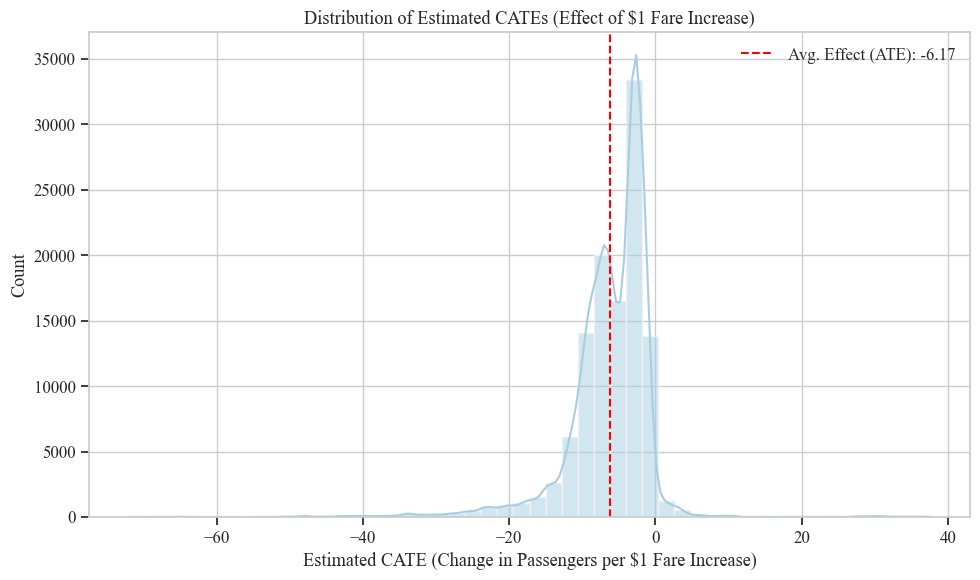

In [147]:
# Visualize CATE distribution
print("Plotting CATE distribution...")
plt.figure(figsize=(10, 6), facecolor='white')
sns.histplot(df_cate_analysis['CATE_fare_on_passengers'], kde=True, bins=50)
plt.title('Distribution of Estimated CATEs (Effect of $1 Fare Increase)')
plt.xlabel('Estimated CATE (Change in Passengers per $1 Fare Increase)')
# Use ATE from LinearDML for comparison
plt.axvline(ate_point_estimate, color='red', linestyle='--', label=f'Avg. Effect (ATE): {ate_point_estimate:.2f}')
plt.legend(); 
plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/R_CML_dist_est_CATEs_CF.png', dpi=500, transparent=True)
plt.show()

### 4.5. Interpret Heterogeneity

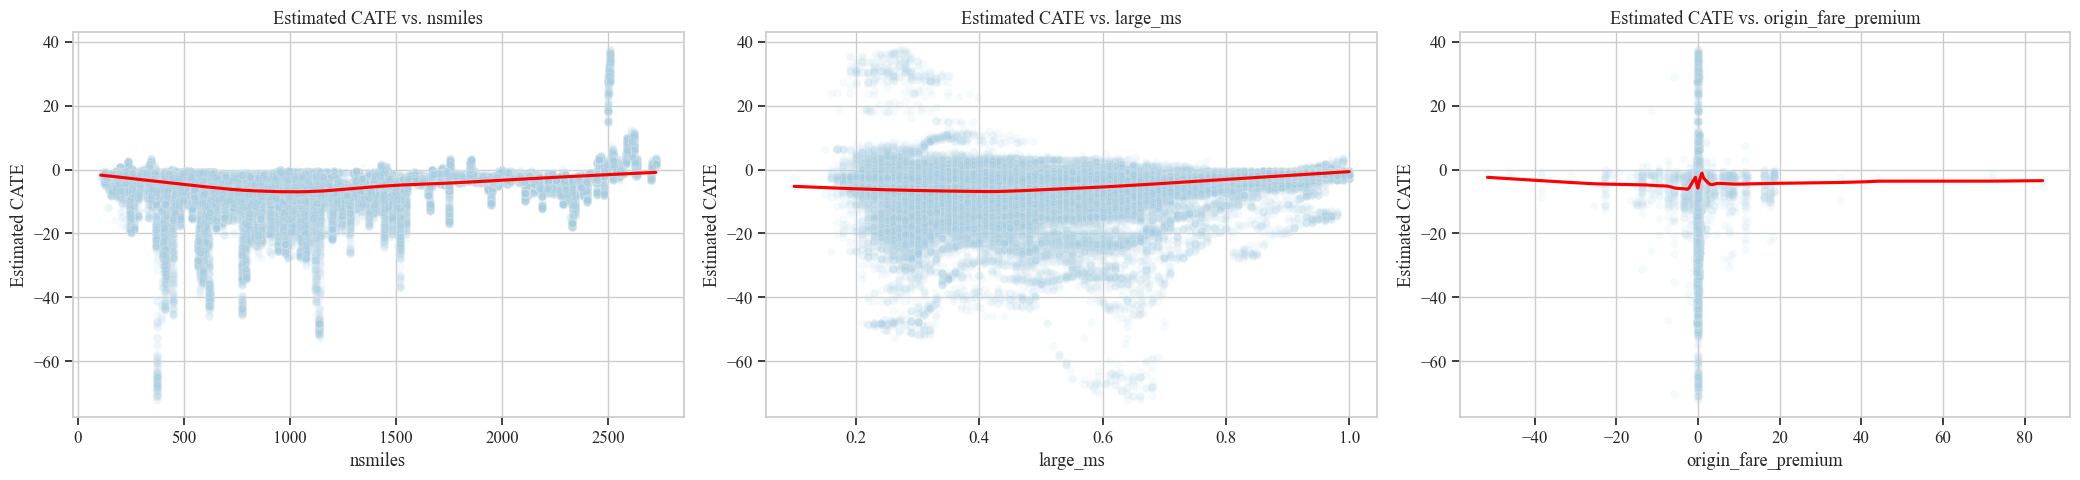

In [148]:
# Plot CATE against key continuous heterogeneity features (original scale)
cont_het_features = ['nsmiles', 'large_ms', 'origin_fare_premium']
cont_het_features = [f for f in cont_het_features if f in df_cate_analysis.columns]
n_plots = len(cont_het_features)
plt.figure(figsize=(7*n_plots, 5), facecolor='white')
for i, col in enumerate(cont_het_features):
    plt.subplot(1, n_plots, i+1)
    sns.scatterplot(data=df_cate_analysis, x=col, y='CATE_fare_on_passengers', alpha=0.1)
    # Add a trend line
    sns.regplot(data=df_cate_analysis, x=col, y='CATE_fare_on_passengers', scatter=False, lowess=True, line_kws={'color': 'red'})
    plt.title(f'Estimated CATE vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Estimated CATE')
    plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/R_CML_CATE_plots_num_vars.png', dpi=500, transparent=True)
plt.show()

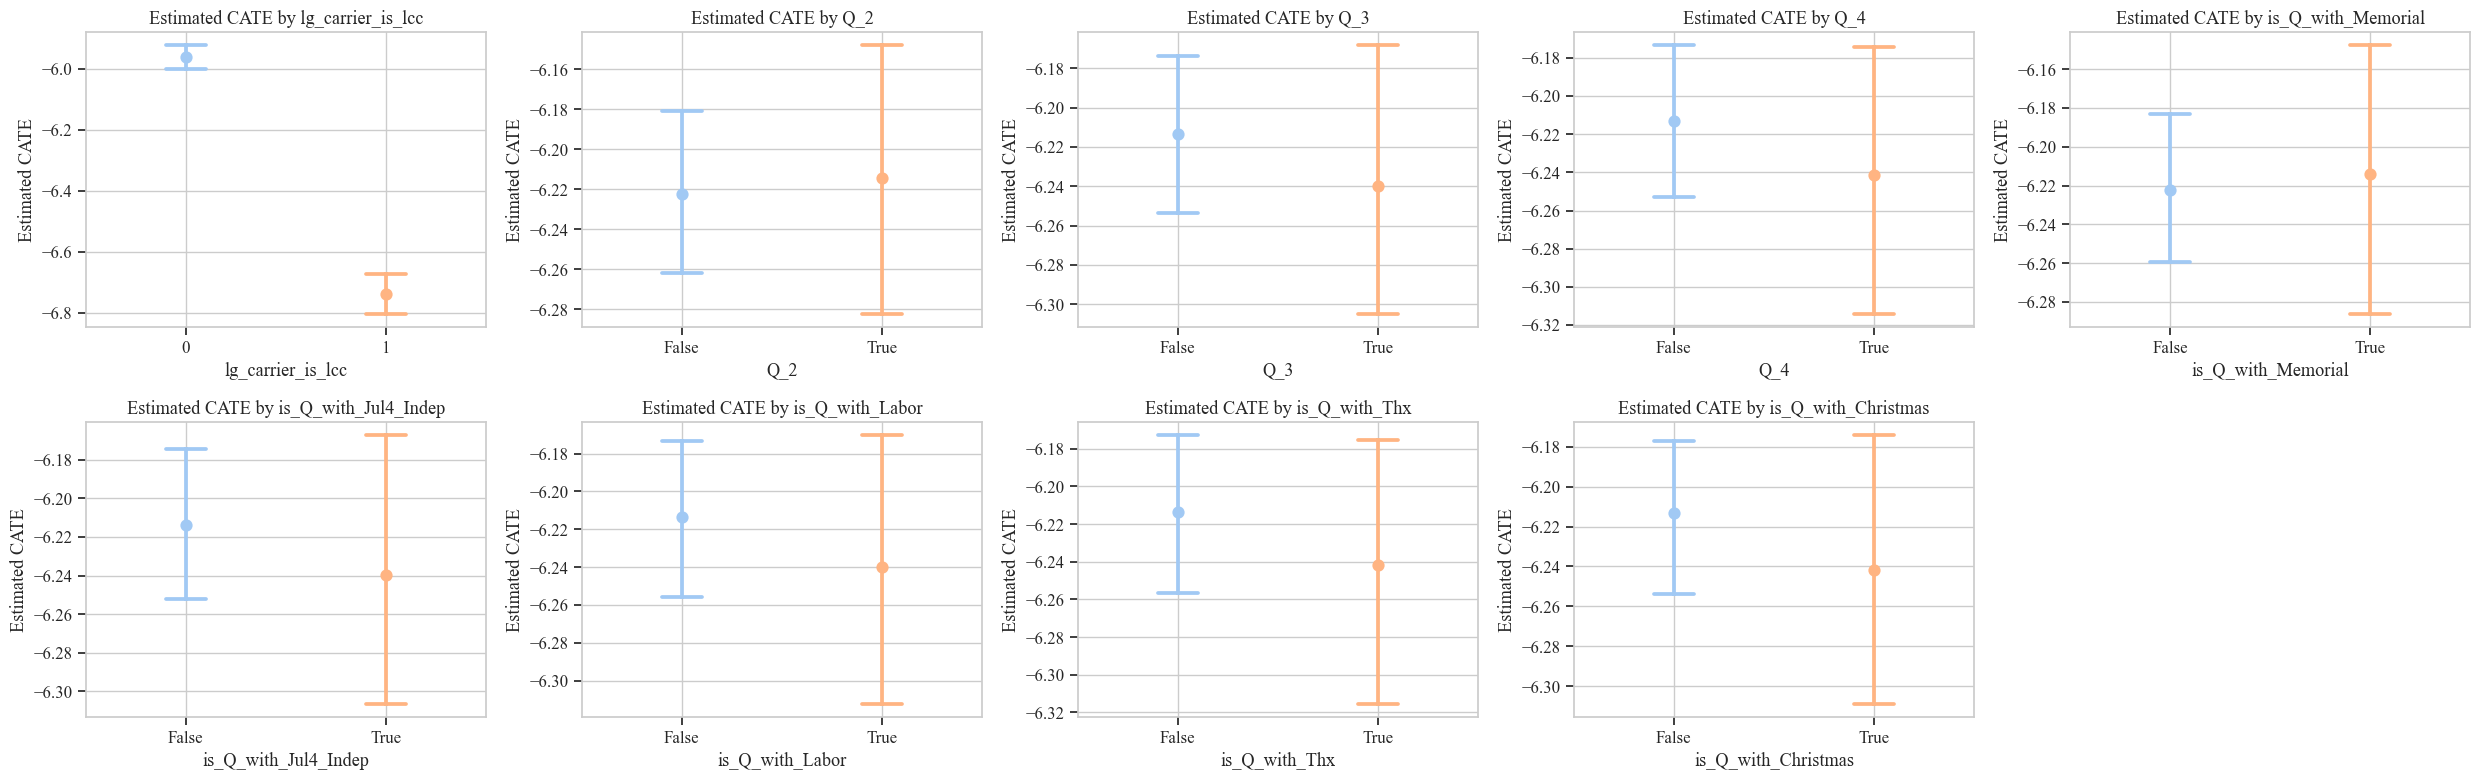

In [149]:
# Plot CATE against key categorical/binary heterogeneity features (original scale)
cat_het_features = ['lg_carrier_is_lcc', 'Q_2', 'Q_3', 'Q_4', 
                    'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 
                    'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas'] 
cat_het_features = [f for f in cat_het_features if f in df_cate_analysis.columns]

n_plots = len(cat_het_features)
max_cols = 5
ncols = min(n_plots, max_cols)
nrows = (n_plots + ncols - 1) // ncols
plt.figure(figsize=(ncols*5, nrows*4), facecolor='white')
for i, col in enumerate(cat_het_features):
    ax = plt.subplot(nrows, ncols, i + 1)
    sns.pointplot(data=df_cate_analysis, x=col, y='CATE_fare_on_passengers', 
                  hue=col, legend=False, errorbar=('ci', 95), capsize=.2,
                  linestyles='none', palette='pastel', ax=ax)
    ax.set_title(f'Estimated CATE by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Estimated CATE')
    ax.grid(True)
plt.tight_layout()
plt.savefig('../outputs/R_CML_CATE_plots_categorical_vars.png', dpi=500, transparent=True)
plt.show()



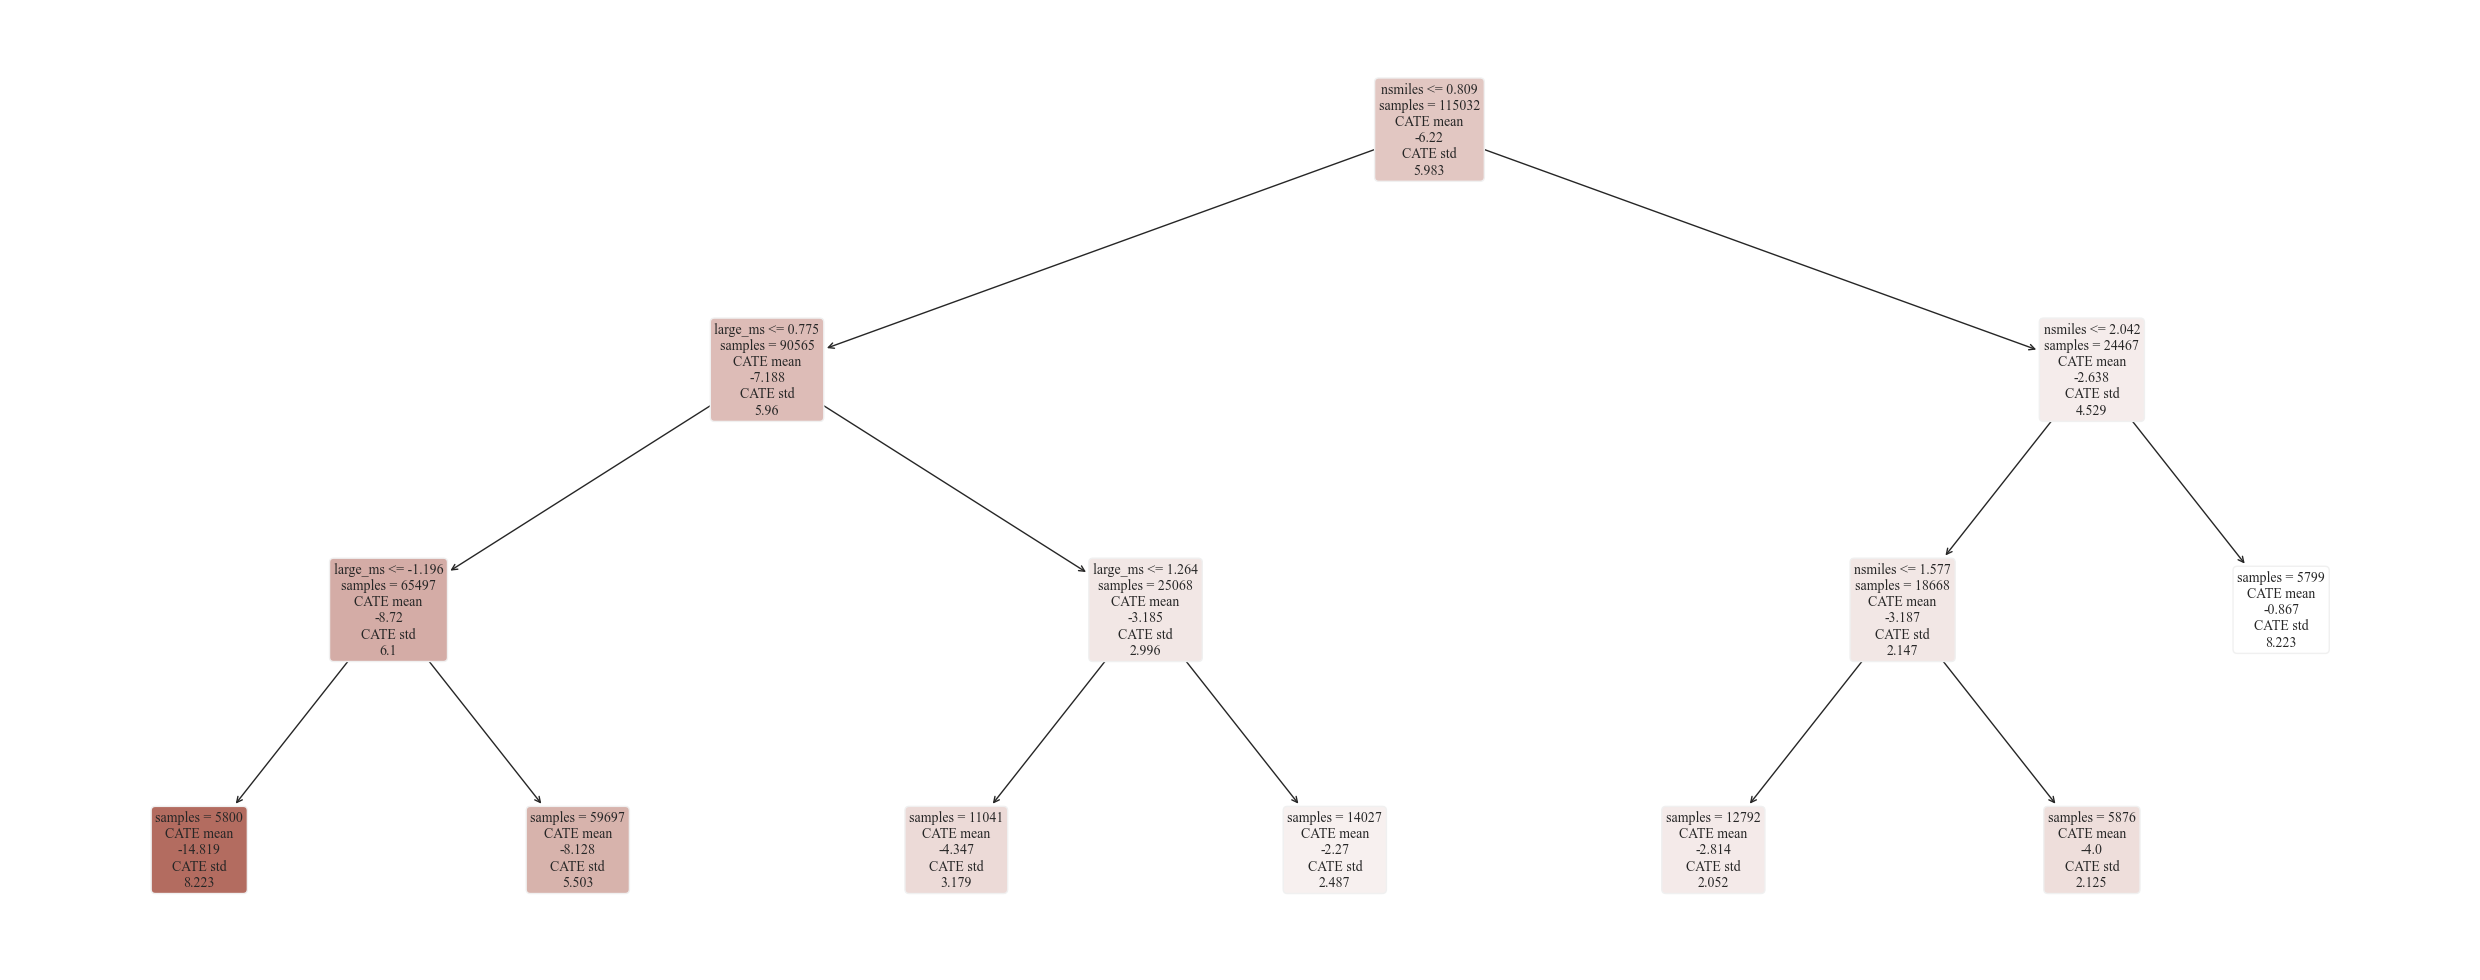

Interpretation: Tree shows features splitting data into segments with different CATEs.


In [150]:
# Interpret with SingleTreeCateInterpreter
# Use the SCALED X_het features (X_het_np) for fitting the tree
# Use original feature names from X_het for plotting labels
X_het_feature_names = X_het.columns.tolist()
tree_interpreter = SingleTreeCateInterpreter(include_model_uncertainty=False, max_depth=3, min_samples_leaf=int(len(df)*0.05))

tree_interpreter.interpret(cf_estimator, X_het_np) # fit interpreter on CATE model & SCALED features X

plt.figure(figsize=(25, 10))
tree_interpreter.plot(feature_names=X_het_feature_names, fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/R_CML_CATE_tree_feature_splitting.png', dpi=500, transparent=True)
plt.show()
print("Interpretation: Tree shows features splitting data into segments with different CATEs.")

## 5. Subgroup ATE Analysis

In [151]:
# Estimate CausalForestDML CATE 
cate_estimates_cfdml = cf_estimator.effect(X_het_np)

In [152]:
# Use CATE estimates from CausalForestDML for subgroup averages
df_cate_analysis = df.copy() 
df_cate_analysis['CATE'] = cate_estimates_cfdml

### 5.1. LCC vs Non-LCC


Calculating ATE for LCC vs Non-LCC subgroups...
                       mean       std  count  ci_lower  ci_upper
lg_carrier_is_lcc                                               
0                 -5.963087  5.544020  76851 -6.002285 -5.923890
1                 -6.737745  6.752318  38181 -6.805476 -6.670015


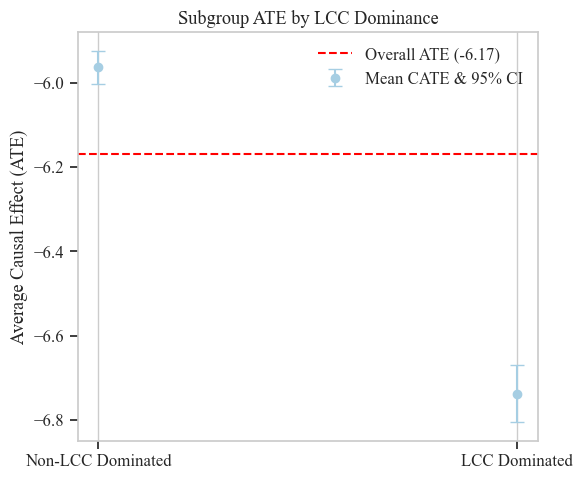

In [153]:
print("\nCalculating ATE for LCC vs Non-LCC subgroups...")
subgroup_ate_lcc = df_cate_analysis.groupby('lg_carrier_is_lcc')['CATE'].agg(['mean', 'std', 'count'])

# Approximate CI: mean +/- 1.96 * (std / sqrt(count))
subgroup_ate_lcc['ci_lower'] = subgroup_ate_lcc['mean'] - 1.96 * (subgroup_ate_lcc['std'] / np.sqrt(subgroup_ate_lcc['count']))
subgroup_ate_lcc['ci_upper'] = subgroup_ate_lcc['mean'] + 1.96 * (subgroup_ate_lcc['std'] / np.sqrt(subgroup_ate_lcc['count']))
print(subgroup_ate_lcc)

# Plot
plt.figure(figsize=(6, 5), facecolor='white')
plt.errorbar(x=subgroup_ate_lcc.index, y=subgroup_ate_lcc['mean'], 
             yerr=(subgroup_ate_lcc['mean'] - subgroup_ate_lcc['ci_lower'], subgroup_ate_lcc['ci_upper'] - subgroup_ate_lcc['mean']),
             fmt='o', capsize=5, label='Mean CATE & 95% CI')
plt.axhline(ate_point_estimate, color='red', linestyle='--', label=f'Overall ATE ({ate_point_estimate:.2f})')
plt.xticks(ticks=[0, 1], labels=['Non-LCC Dominated', 'LCC Dominated'])
plt.ylabel('Average Causal Effect (ATE)')
plt.title('Subgroup ATE by LCC Dominance')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../outputs/R_CML_subgroup_ATE_by_LCC.png', dpi=500, transparent=True)
plt.show()

### 5.2. Distance Categories


Calculating ATE for Distance Categories...
                  mean       std  count  ci_lower  ci_upper
distance_cat                                               
Short        -5.997997  6.698679  38522 -6.064891 -5.931102
Medium       -8.005783  5.441176  38427 -8.060187 -7.951379
Long         -4.643280  5.207859  38083 -4.695586 -4.590974


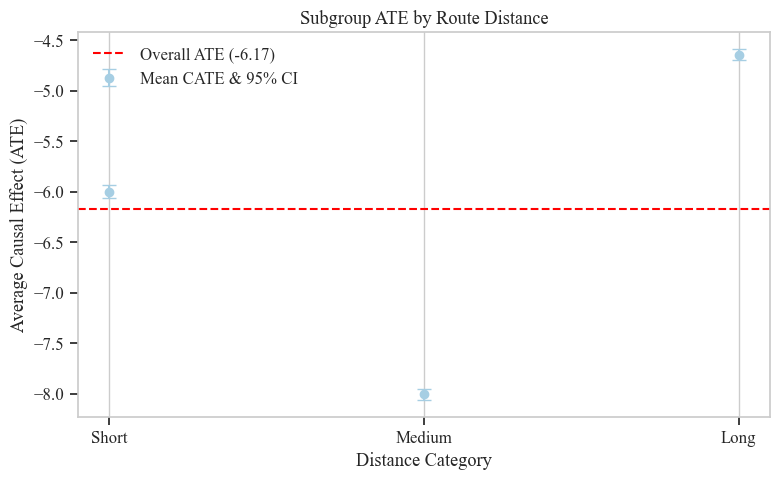

In [154]:
print("\nCalculating ATE for Distance Categories...")

# Use original nsmiles for categorization
df_cate_analysis['distance_cat'] = pd.qcut(df['nsmiles'].astype(float), q=3, labels=['Short', 'Medium', 'Long'], duplicates='drop')
subgroup_ate_dist = df_cate_analysis.groupby('distance_cat', observed=False)['CATE'].agg(['mean', 'std', 'count'])
subgroup_ate_dist['ci_lower'] = subgroup_ate_dist['mean'] - 1.96 * (subgroup_ate_dist['std'] / np.sqrt(subgroup_ate_dist['count']))
subgroup_ate_dist['ci_upper'] = subgroup_ate_dist['mean'] + 1.96 * (subgroup_ate_dist['std'] / np.sqrt(subgroup_ate_dist['count']))
print(subgroup_ate_dist)

plt.figure(figsize=(8, 5), facecolor='white')
plt.errorbar(x=subgroup_ate_dist.index, y=subgroup_ate_dist['mean'],
             yerr=(subgroup_ate_dist['mean'] - subgroup_ate_dist['ci_lower'], subgroup_ate_dist['ci_upper'] - subgroup_ate_dist['mean']),
             fmt='o', capsize=5, label='Mean CATE & 95% CI')
plt.axhline(ate_point_estimate, color='red', linestyle='--', label=f'Overall ATE ({ate_point_estimate:.2f})')
plt.ylabel('Average Causal Effect (ATE)')
plt.xlabel('Distance Category')
plt.title('Subgroup ATE by Route Distance')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../outputs/R_CML_subgroup_ATE_by_distance.png', dpi=500, transparent=True)
plt.show()


### 5.3. CATE DECILE PLOT

Creating CATE Decile Plot...


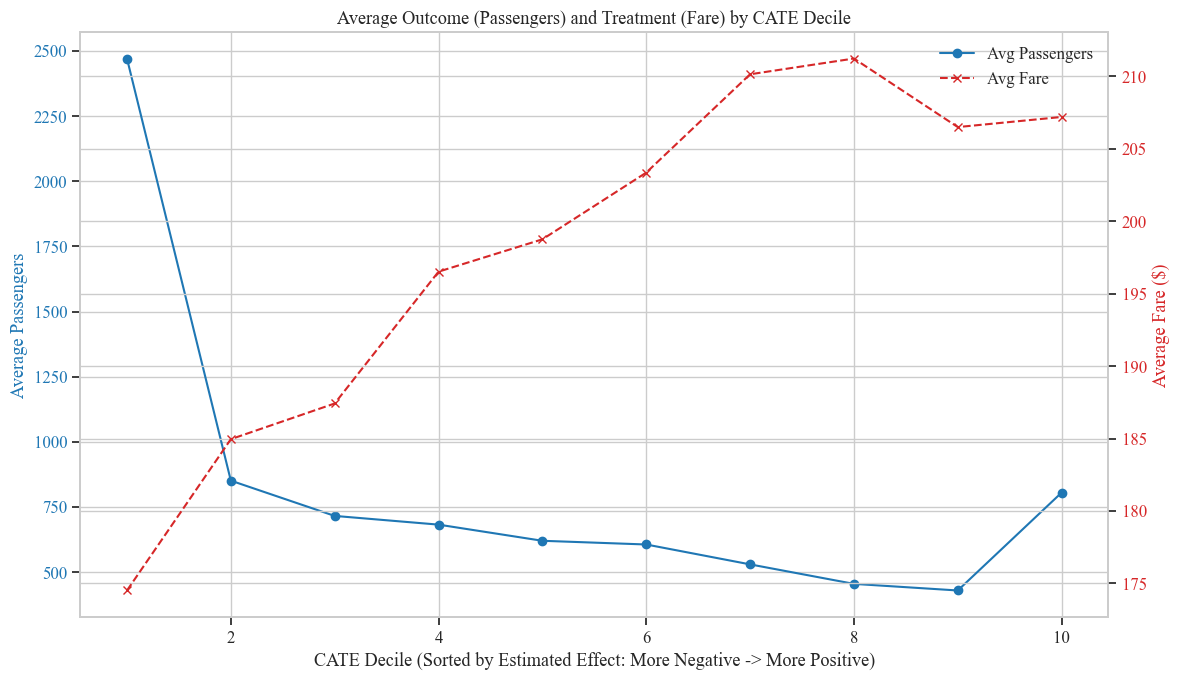


Interpretation:
Check trends across deciles, e.g., do deciles with more negative CATEs (higher price sensitivity) show lower average passengers?


In [155]:
print("Creating CATE Decile Plot...")
# plt.style.use('seaborn-v0_8-whitegrid')

# Use df_cate_analysis which has unscaled features and CATEs
df_decile = df.copy() 
df_decile['CATE'] = cate_estimates_cfdml 

# Sort by CATE and create deciles
df_decile = df_decile.sort_values('CATE')
df_decile['CATE_decile'] = pd.qcut(df_decile['CATE'], q=10, labels=False, duplicates='drop') + 1 # labels 1-10

# Calculate average outcome and treatment per decile
decile_agg = df_decile.groupby('CATE_decile')[['passengers', 'fare', 'CATE']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 7))
# fig.set_facecolor('white')
# ax1.set_facecolor('white')

color1 = 'tab:blue'
ax1.set_xlabel('CATE Decile (Sorted by Estimated Effect: More Negative -> More Positive)')
ax1.set_ylabel('Average Passengers', color=color1)
ax1.plot(decile_agg['CATE_decile'], decile_agg['passengers'], color=color1, marker='o', label='Avg Passengers')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()
# ax2.set_facecolor('white')
color2 = 'tab:red'
ax2.set_ylabel('Average Fare ($)', color=color2)
ax2.plot(decile_agg['CATE_decile'], decile_agg['fare'], color=color2, marker='x', linestyle='--', label='Avg Fare')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Average Outcome (Passengers) and Treatment (Fare) by CATE Decile')
lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')
fig.tight_layout()
plt.savefig('../outputs/R_CML_CATE_decile_plot.png', dpi=500, transparent=True)
plt.show()

print("\nInterpretation:\nCheck trends across deciles, e.g., do deciles with more negative CATEs (higher price sensitivity) show lower average passengers?")

## 6. Sensitivity Analysis (dowhy)

Test robustness to unobserved confounders

### 6.1. Create DoWhy Causal Model

In [127]:
dowhy_cols = [OUTCOME_CAUSAL, TREATMENT_CAUSAL] + confounders_causal
df_dowhy = df[dowhy_cols].copy()

# Convert boolean/Int64 columns to int/float for dowhy compatibility
for col in df_dowhy.columns:
    if is_bool_dtype(df_dowhy[col]):
        df_dowhy[col] = df_dowhy[col].astype(int)
    elif pd.api.types.is_integer_dtype(df_dowhy[col]):
        df_dowhy[col] = df_dowhy[col].astype(float)

# Define graph structure: W -> T, W -> Y
confounder_names_dowhy = W.columns.tolist() # get final confounder names
graph_str = "digraph { "
graph_str += f"{TREATMENT_CAUSAL} [label={TREATMENT_CAUSAL}]; "
graph_str += f"{OUTCOME_CAUSAL} [label={OUTCOME_CAUSAL}]; "

# Ensure confounder names are quoted if they contain special characters ('_')
for w in confounder_names_dowhy:
    graph_str += f"\"{w}\" [label=\"{w}\"]; " # add nodes for W (quoted)
    graph_str += f"\"{w}\" -> {TREATMENT_CAUSAL}; " # W -> T edges
    graph_str += f"\"{w}\" -> {OUTCOME_CAUSAL}; " # W -> Y edges
graph_str += f"{TREATMENT_CAUSAL} -> {OUTCOME_CAUSAL}; " # T -> Y edge
graph_str += "}"

In [128]:
print("Assumed Graph for DoWhy:\n", graph_str[:200] + "...") 
# Initialize CausalModel
model_dowhy = CausalModel(
    data=df_dowhy,
    treatment=TREATMENT_CAUSAL,
    outcome=OUTCOME_CAUSAL,
    graph=graph_str 
)
print("DoWhy CausalModel initialized.")

Assumed Graph for DoWhy:
 digraph { fare [label=fare]; passengers [label=passengers]; "nsmiles" [label="nsmiles"]; "nsmiles" -> fare; "nsmiles" -> passengers; "large_ms" [label="large_ms"]; "large_ms" -> fare; "large_ms" -> pa...
DoWhy CausalModel initialized.


### 6.2. Identify Estimand

In [129]:
identified_estimand = model_dowhy.identify_effect(proceed_when_unidentifiable=True)
print("\nIdentified Estimand:")
print(identified_estimand)


Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
───────(E[passengers|is_Q_with_Labor,nsmiles,dest_perc_lcc_pax,is_Q_with_NYD,Q
d[fare]                                                                       

                                                                              
_3,is_Q_with_Memorial,Year,is_Q_with_Any_Holiday,lf_ms,carrier_DL,origin_fare_
                                                                              

                                                                              
premium,Q_2,is_Q_with_Christmas,is_Q_with_Jul4_Indep,Q_4,origin_perc_lcc_pax,l
                                                                              

                                                                              
arge_ms,is_Q_with_Thx,carrier_AA,lg_carrier_is_lcc,carrier_WN,dest_fare_prem

The primary identification strategy (controlling for the observed confounders W using the backdoor criterion, which is what DML does) is valid according to the causal graph you assumed. 

=> can proceed with the estimation and refutation steps based on this identification result.

### 6.3. Use Pre-calculated ATE

In [130]:
ate_estimate_dowhy = ate_point_estimate # from LinearDML part
print(f"\nUsing ATE estimate from LinearDML: {ate_estimate_dowhy:.3f}")


Using ATE estimate from LinearDML: -6.168


### 6.4. Perform Sensitivity Analysis (Add Unobserved Confounder)

/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

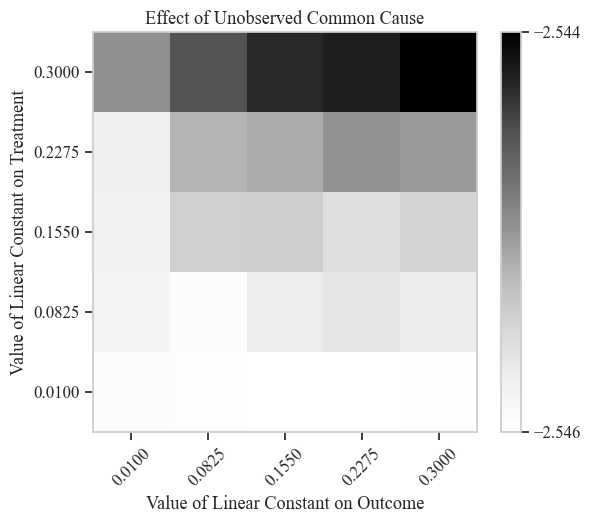


Sensitivity Analysis Results:
Refute: Add an Unobserved Common Cause
Estimated effect:-6.168290050364359
New effect:(-2.5464508636523533, -2.5437798506327454)



In [131]:
# This checks how strong an unobserved confounder would need to be to change the conclusion
# Provide the estimate object directly to the refuter
dummy_estimate = model_dowhy.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=False)
dummy_estimate.value = ate_estimate_dowhy # use DML estimate

sensitivity_results = model_dowhy.refute_estimate(
    identified_estimand,
    dummy_estimate, # pass the estimate object with the value
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=np.linspace(0.01, 0.3, 5), 
    effect_strength_on_outcome=np.linspace(0.01, 0.3, 5)
)

print("\nSensitivity Analysis Results:")
print(sensitivity_results)
# Interpretation: Look at the 'New Effect'.

**Purpose**

This test checks how robust your estimated ATE (Estimated effect: -6.155) is to a potential unobserved confounder that might affect both fare (treatment) and passengers (outcome). It simulates such a confounder with varying strengths (affecting treatment and outcome with correlations from 0.01 up to 0.3, based on the linspace settings).

**Result**

The New effect: (-2.546..., -2.543...) shows the range of ATE estimates produced under these different simulated confounding scenarios.

=> Even when assuming an unobserved confounder with a reasonably strong linear effect (up to 0.3 correlation with both treatment and outcome), the estimated treatment effect remains consistently negative and does not cross zero. While the magnitude changes (from -6.16 down to around -2.64), the core conclusion of a negative effect holds. 

=> This suggests the finding is relatively robust to unobserved confounding of this magnitude. The heatmap visually confirms that the estimated effect stays negative across the tested range of confounder strengths.

In [132]:
# --- 2.5: Perform Placebo Treatment Refutation ---
print("\nPerforming Placebo Treatment Refutation...")
placebo_results = model_dowhy.refute_estimate(
    identified_estimand,
    dummy_estimate, # pass the estimate object
    method_name="placebo_treatment_refuter",
    placebo_type="permute", num_simulations=100 
)
print("\nPlacebo Treatment Refutation Results:")
print(placebo_results)
# Interpretation: 'New Effect' should be close to zero, p-value high.


Performing Placebo Treatment Refutation...


/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate


Placebo Treatment Refutation Results:
Refute: Use a Placebo Treatment
Estimated effect:-6.168290050364359
New effect:0.00055316190610597
p value:0.8999999999999999



/Applications/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


**Placebo Treatment Refutation (placebo_treatment_refuter)**

This test replaces the actual treatment (fare) with random noise (a placebo that should have no real effect) and re-estimates the effect. 
A good causal model should find an effect close to zero for the placebo.

*Result* 

The output shows New effect: -0.008... (very close to zero) and P-value: 0.9 > 0.05... (very high).

A high p-value means we cannot reject the null hypothesis that the effect of the placebo treatment is zero. In other words, the model correctly found no statistically significant effect when the real treatment was replaced by random noise.

The significant negative effect you found for the actual fare treatment (ATE ≈ -6.16) is likely a genuine causal finding related to fare itself, rather than just an artifact of the model finding patterns in noise.

Both refutation tests provide positive support for the estimated ATE. 

## 7. SHAP Values For Nuisance Models

### 7.1. Re-fit Nuisance Models Explicitly (for SHAP)

In [157]:
# Model E[Y|W]
print("Fitting model E[Y|W]...")
model_y_shap = GradientBoostingRegressor(n_estimators=50, max_depth=4, min_samples_leaf=15, random_state=42)
model_y_shap.fit(W_np, Y_np) 

# Model E[T|W]
print("Fitting model E[T|W]...")
model_t_shap = GradientBoostingRegressor(n_estimators=50, max_depth=4, min_samples_leaf=15, random_state=123)
model_t_shap.fit(W_np, T_np) 

Fitting model E[Y|W]...
Fitting model E[T|W]...


GradientBoostingRegressor(max_depth=4, min_samples_leaf=15, n_estimators=50,
                          random_state=123)

### 7.2. Calculate SHAP Values

In [158]:
print("Calculating SHAP values (this may take time)...")
# Use TreeExplainer for GradientBoosting models
explainer_y = shap.TreeExplainer(model_y_shap)
shap_values_y = explainer_y.shap_values(W_np) # use scaled W

explainer_t = shap.TreeExplainer(model_t_shap)
shap_values_t = explainer_t.shap_values(W_np) # use scaled W

Calculating SHAP values (this may take time)...


### 7.3. Plot SHAP Summary Plots

Times New Roman font is available.

SHAP Summary Plot for E[Y|W] (Outcome Model):


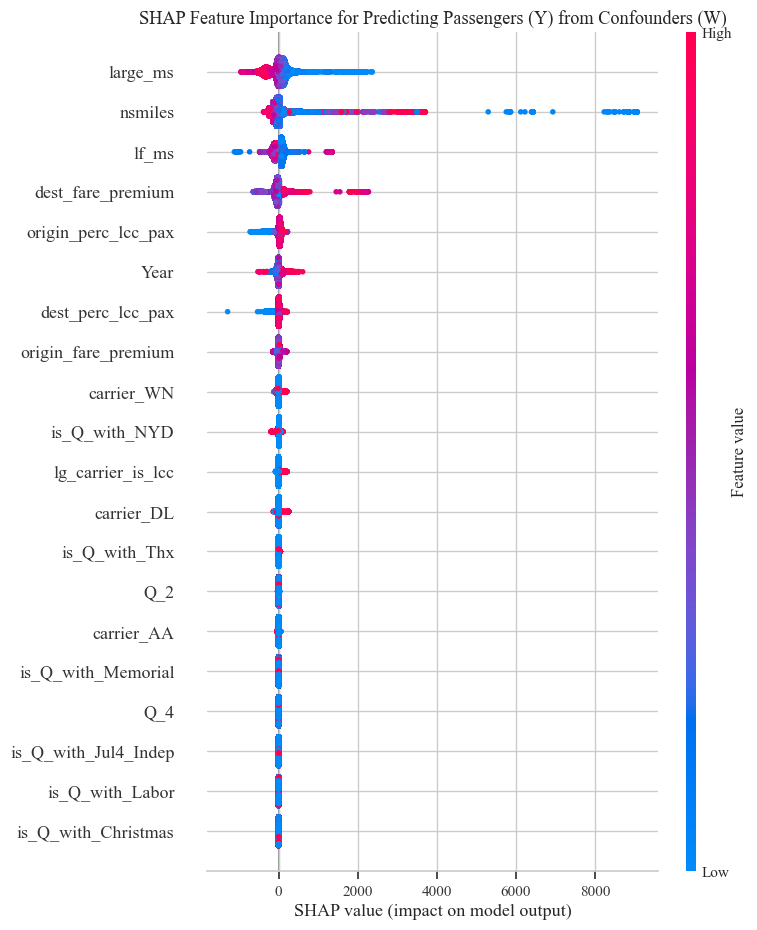

Interpretation:
Shows which confounders have the biggest impact on predicting passengers.

SHAP Summary Plot for E[T|W] (Treatment Model):


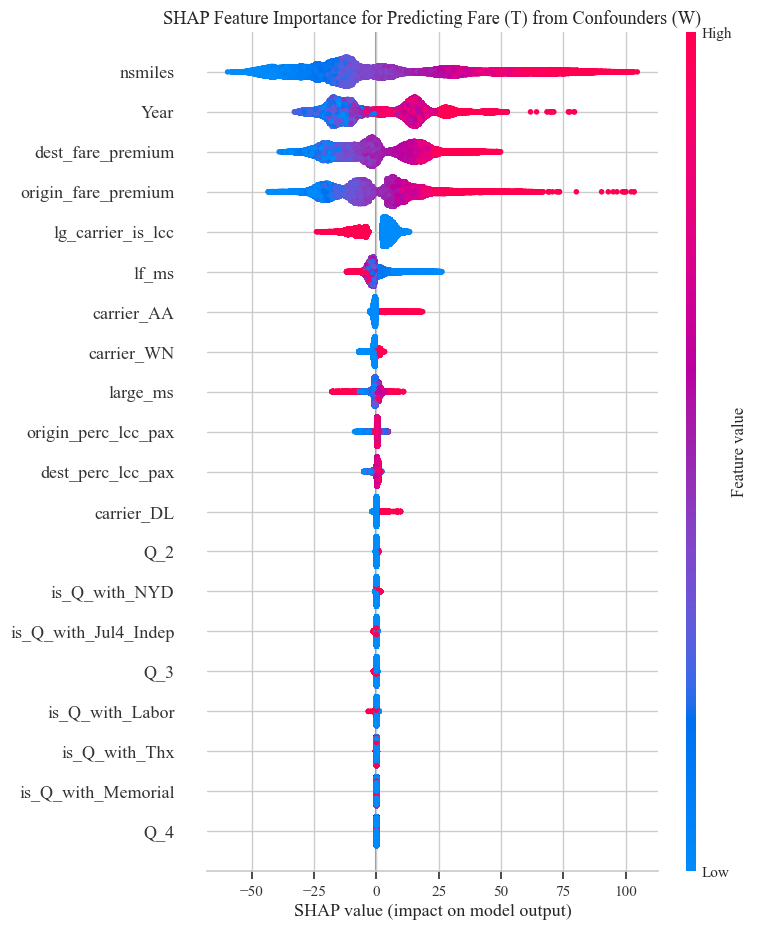

Interpretation:
Shows which confounders have the biggest impact on predicting fare.


In [161]:
import matplotlib.font_manager as fm

plt.style.use('seaborn-v0_8-whitegrid')

if 'Times New Roman' in [f.name for f in fm.fontManager.ttflist]:
    print("Times New Roman font is available.")
    # Set Times New Roman as the default font for the 'serif' family
    matplotlib.rcParams['font.family'] = 'serif'
    matplotlib.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
else:
    print("Times New Roman font is not available. Using default font.")
    
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (11, 6)

W_df_scaled = pd.DataFrame(W_np, columns=W.columns) 

print("\nSHAP Summary Plot for E[Y|W] (Outcome Model):")
shap.summary_plot(shap_values_y, W_df_scaled, show=False)
plt.title('SHAP Feature Importance for Predicting Passengers (Y) from Confounders (W)')
plt.tight_layout()
plt.savefig('../outputs/R_CML_SHAP_predY_from_W.png', dpi=500, transparent=True)
plt.show()
print("Interpretation:\nShows which confounders have the biggest impact on predicting passengers.")

print("\nSHAP Summary Plot for E[T|W] (Treatment Model):")
shap.summary_plot(shap_values_t, W_df_scaled, show=False)
plt.title('SHAP Feature Importance for Predicting Fare (T) from Confounders (W)')
plt.tight_layout()
plt.savefig('../outputs/R_CML_SHAP_predT_from_W.png', dpi=500, transparent=True)
plt.show()
print("Interpretation:\nShows which confounders have the biggest impact on predicting fare.")

## 6. Final Causal Explanation

In [136]:
print("\n--- Causal Explanation Summary ---")
print(f"The estimated average causal effect (ATE) of a $1 increase in fare is a change of ~{ate_point_estimate:.1f} passengers/day.")
print("However, this effect varies across markets (CATE). Key factors driving heterogeneity may include:")

# Refer to findings from CATE distribution, plots vs features, and interpreter tree
significant_drivers = []
significant_drivers.append("Route distance ('nsmiles')")
significant_drivers.append("Dominant carrier type (LCC vs. Legacy)")
significant_drivers.append("Origin city fare premium level")
significant_drivers.append("Seasonality (Quarter)")
significant_drivers.append("Presence of major holidays")

if significant_drivers:
    for driver in significant_drivers:
        print(f"- {driver}")
else:
    print("- (Further investigation needed to pinpoint significant drivers)")

print("\nUnderstanding these varying effects is crucial for targeted pricing strategies.")



--- Causal Explanation Summary ---
The estimated average causal effect (ATE) of a $1 increase in fare is a change of ~-6.2 passengers/day.
However, this effect varies across markets (CATE). Key factors driving heterogeneity may include:
- Route distance ('nsmiles')
- Dominant carrier type (LCC vs. Legacy)
- Origin city fare premium level
- Seasonality (Quarter)
- Presence of major holidays

Understanding these varying effects is crucial for targeted pricing strategies.
